# Private Support Points: Regression Examples

___

In [1]:
import json
import logging
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import os
import pdb
import sklearn
from sklearn.datasets import load_boston, load_diabetes, fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import PolynomialFeatures

import time

from sp_utils import (
    scale_01,
    get_energy_sensitivity,
    get_support_points,
    energy,
    sample_sp_exp_mech,
    #sample_sp_mmd_dp_bw,
    mixture_model_likelihood,
    sample_full_set_given_bandwidth)

plt.style.use('ggplot')
#font = {'family' : 'normal',
#        'size'   : 14}
#matplotlib.rc('font', **font)

In [2]:
# Set up logging.
log_filename = '../output/regression_logs/run.log'
if os.path.isfile(log_filename):
    os.remove(log_filename)
logging.basicConfig(filename=log_filename,
                             filemode='a',
                             format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                             datefmt='%H:%M:%S',
                             level=logging.DEBUG)
mpl_logger = logging.getLogger('matplotlib') 
mpl_logger.setLevel(logging.WARNING)
_LOG = logging.getLogger('[perturbed]')

# Support points accurately model toy multivariate data in 5D.

In [3]:
def plot_nd(d, w=10, h=10, title=None):
    graph = pd.plotting.scatter_matrix(pd.DataFrame(d), figsize=(w, h));
    if title:
        plt.suptitle(title)
    plt.show()


STARTING RUN. is_tf: True, y_init: uniform, clip: bounds, wlb: False
  [*] Using TensorFlow optimization.


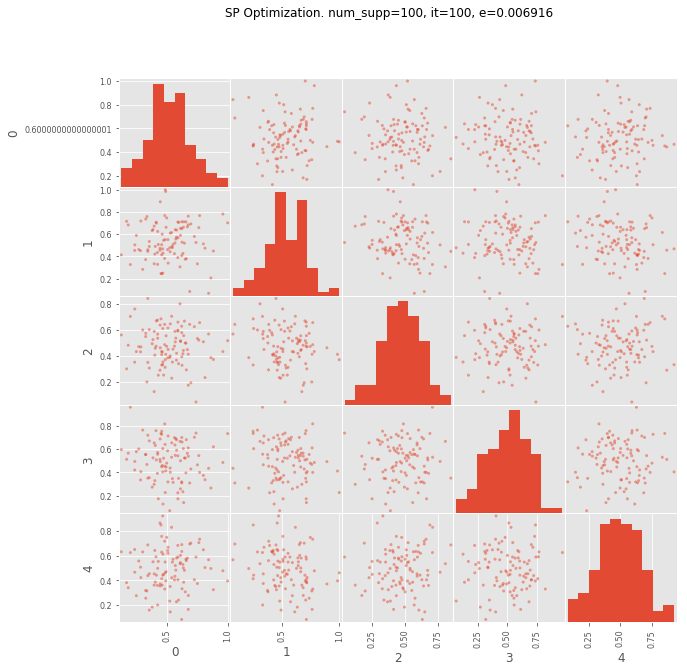

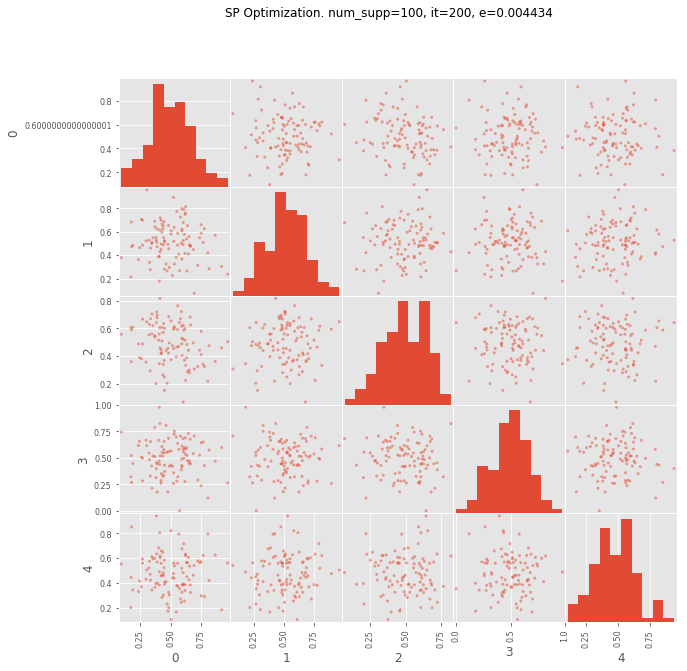

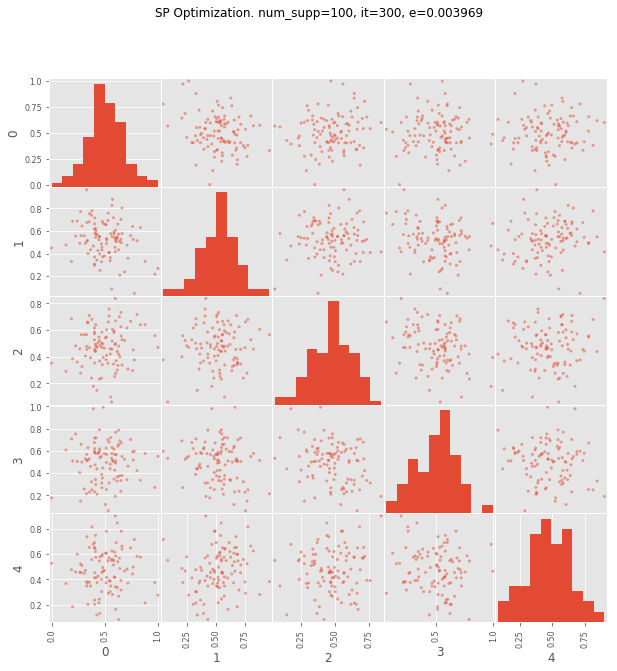

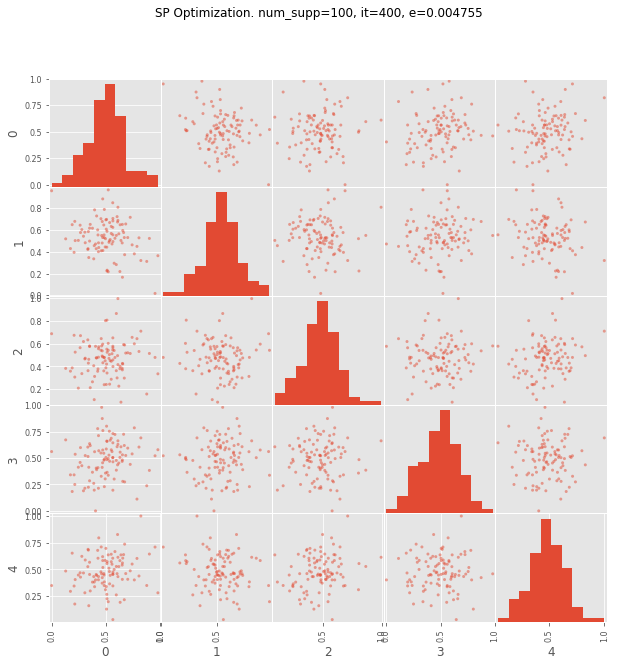

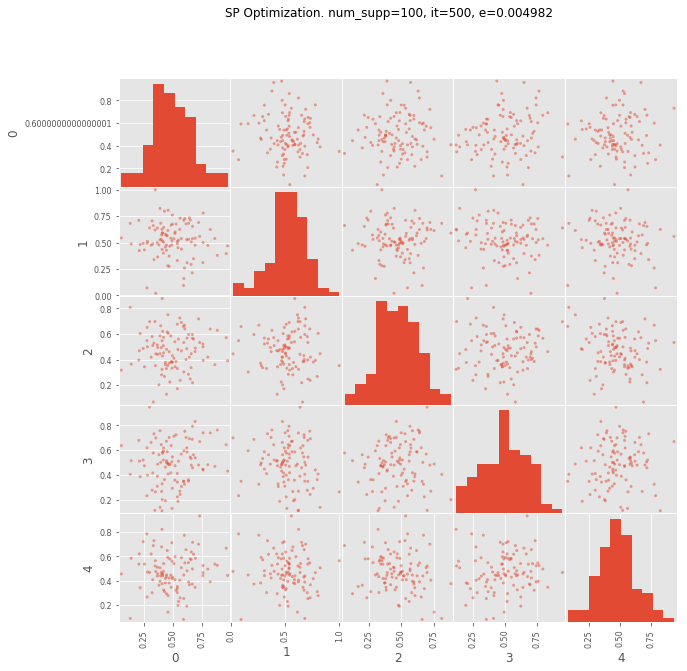

  [*] Time elapsed: 27.19


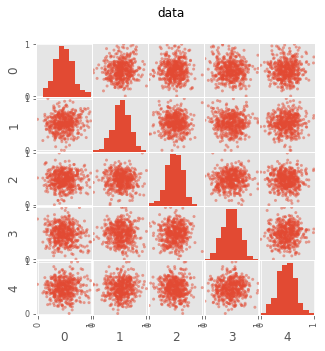

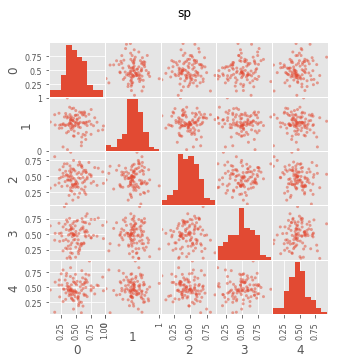

In [15]:
# Test support points on multivariate Gaussian data.
if 1:
    num_data = 500
    DIM = 5
    data = np.random.normal(0, 1, size=(num_data, DIM))
    data = scale_01(data)
    num_supp = 100
    MAX_ITER = 501 #300
    LR = 1e-1 #1e1
    ENERGY_POWER = 1

    y_opt, e_opt = get_support_points(data, num_supp, MAX_ITER, LR, is_tf=True,
                                      power=ENERGY_POWER, y_init_option='uniform',
                                      clip='bounds')

    plot_nd(pd.DataFrame(data), 5, 5, 'data')
    plot_nd(pd.DataFrame(y_opt), 5, 5, 'sp')

# Test variance of Support Point Optimization vs variance of Metropolis Hastings Sampling.


STARTING RUN. is_tf: True, y_init: uniform, clip: data, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 2.05

STARTING RUN. is_tf: True, y_init: uniform, clip: data, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 2.03

STARTING RUN. is_tf: True, y_init: uniform, clip: data, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 1.99


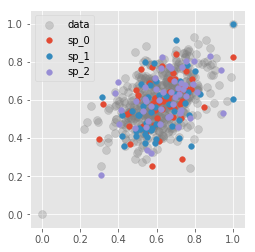


STARTING RUN. is_tf: True, y_init: uniform, clip: data, wlb: False
  [*] Using TensorFlow optimization.
  [*] Time elapsed: 2.34

Pr(e) = a / (2U) * exp(- a / (2U) * e) ~ Exp(2U/a) = Exp(2 * 0.1120 / 1000.000) = Exp(0.00022401)

Running chain. Length=11000, Burn=5000, Thin=2000
Difference factor: 4464.06

acceptance_rate=1.00000000, step_size=0.01000000
Energy diff: 0.00001190
acceptance_rate=0.38873751, step_size=0.25000000
Energy diff: 0.00119590
acceptance_rate=0.34529759, step_size=0.25000000
Energy diff: 0.00064388
acceptance_rate=0.34141169, step_size=0.25000000
Energy diff: 0.00076428
acceptance_rate=0.34037719, step_size=0.25000000
Energy diff: -0.00039782
acceptance_rate=0.34121069, step_size=0.25000000
Energy diff: 0.00064511
acceptance_rate=0.33555522, step_size=0.25000000
Energy diff: 0.00051111
acceptance_rate=0.33255421, step_size=0.25000000
Energy diff: 0.00039242
acceptance_rate=0.33223497, step_size=0.25000000
Energy diff: 0.00063753
acceptance_rate=0.33410767, step_s

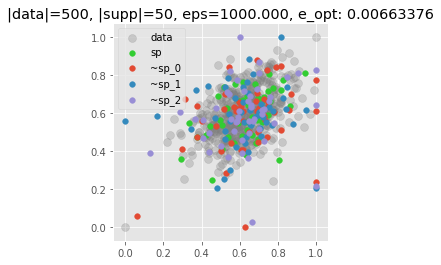

In [25]:
num_data = 500
num_supp = 50
DIM = 2
MAX_ITER = 201
LR = 5e-1
ALPHA = 1000
POWER = 2


num_sp_samples = 3

# Make data.
mean = [0, 0]
cov = [[1, 0.5], [0.5, 1]]
data = np.random.multivariate_normal(mean, cov, [num_data])
data = scale_01(data)
energy_sensitivity = get_energy_sensitivity(data, num_supp, power=POWER)


if 1:

    # ------------------------------------------------------------------
    # Given data, repeated support point optimizations are low variance.
    # ------------------------------------------------------------------

    plt.scatter(data[:, 0], data[:, 1], c='gray', s=64,
                alpha=0.3, label='data')
    for i in range(num_sp_samples):
        y_opt, e_opt = get_support_points(data, num_supp, MAX_ITER, LR, is_tf=True,
                                          power=POWER, y_init_option='uniform',
                                          clip='data', plot=False)
        plt.scatter(y_opt[:, 0], y_opt[:, 1], s=32, label='sp_{}'.format(i))

    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.show()


    # ---------------------------------------------------------------
    # Given support points, repeated samples from Exp.Mech. creates more variance.
    # ---------------------------------------------------------------

    # Get private support points.
    y_opt, e_opt = get_support_points(data, num_supp, MAX_ITER, LR, is_tf=True,
                                      power=POWER, y_init_option='uniform',
                                      clip='data', plot=False)
    (y_tildes,
     energies,
     energy_errors) = sample_sp_exp_mech(e_opt, energy_sensitivity, data, y_opt,
                                         method='mh', num_y_tildes=num_sp_samples,
                                         alpha=ALPHA,
                                         save_dir='../output/regression_logs',
                                         power=POWER,)

    plt.scatter(data[:, 0], data[:, 1], c='gray', s=64,
                alpha=0.3, label='data')
    plt.scatter(y_opt[:, 0], y_opt[:, 1], s=32, c='limegreen',
                label='sp')
    for i in range(num_sp_samples):
        y_priv = y_tildes[i]
        plt.scatter(y_priv[:, 0], y_priv[:, 1], s=32, label='~sp_{}'.format(i))
    plt.title(('|data|={}, |supp|={}, eps={:.3f}, e_opt: {:.8f}').format(
                   num_data, num_supp, ALPHA, e_opt))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend()
    plt.show()

___

# Regression task.

In [ ]:
def test_regression(data, data_heldout):
    """Computes regression accuracy, averaged over multiple runs.
    
    Each run computes accuracy with k-fold cross validation.
    
    Args:
      data (array): Training data.
      data_heldout (array): Testing/heldout data.
    
    Returns:
      result (scalar): MSE value on test data.
    """
    
    def regress(X_train, X_test, Y_train, Y_test, polynomial=False):
        if polynomial:
            poly = PolynomialFeatures(degree=3)
            X_train = poly.fit_transform(X_train)
            X_test = poly.fit_transform(X_test)
            
        # Fits linear model given a train-test split.
        # Returns MSE value of fitted model.
        lm = LinearRegression()
        lm.fit(X_train, Y_train)

        Y_pred = lm.predict(X_test)
        mse = mean_squared_error(Y_test, Y_pred)

        return mse
    
    """
    def regress(X_train, X_test, Y_train, Y_test):
        # Fits linear model given a train-test split.
        # Returns MSE value of fitted model.
        lm = LinearRegression()
        lm.fit(X_train, Y_train)

        Y_pred = lm.predict(X_test)
        mse = mean_squared_error(Y_test, Y_pred)
        r2 = lm.score(X_test, Y_test)
        
        return mse
    """
        
    result = regress(data[:, :-1], data_heldout[:, :-1],
                     data[:, -1], data_heldout[:, -1], polynomial=True)
    
    return result

## Helper functions for running experiments.

In [ ]:
from collections import namedtuple
Result = namedtuple('Result', 'dataset_name size alpha mse std tag')


def visualize_data(data, title=None):
    # Visualize data with pairs plot.
    if len(data) >= 1000:
        _d = data[np.random.choice(len(data), 500)]             
        plot_nd(_d, 10, 10, title)
    else:
        plot_nd(data, 10, 10, title)


def round_binary_cols(data, binary_cols):
    """Rounds binary cols of a NumPy array."""
    for col in binary_cols:
        col_data = data[:, col]
        col_data = np.clip(col_data, 0, 1)
        col_data = np.round(col_data)
        data[:, col] = col_data
    return data


def get_accuracy_mean_std_on_heldout(candidate_sets, heldout, data,
                                     dataset_name, num_supp, alpha=None, tag=None):
    """Computes regression accuracy results for a multiset of candidate points.
    
    Multiset can be random subsets of data, can be sets of support points, or
    can be sets of privatized support points.

    Args:
        candidate_sets (array): Multiset of candidate points.
        heldout (array): Array of test data.
        data (array): Data for plotting.
        dataset_name (string): Name of data set.
        num_supp (int): Number of support points.
        alpha (float): Privacy budget.
        tag (string): Tag for Result object.

    Returns:
        result_priv (Result): Named tuple of result for private support points.
    """
    # Collect accuracy values for each sample.
    accuracies = []
    for candidate_set in candidate_sets:
        accuracy = test_regression(candidate_set, heldout)
        accuracies.append(accuracy)
    _LOG.info('accuracies_min_max = {}, {}'.format(min(accuracies),
                                                   max(accuracies)))
    _LOG.info('accuracies_std = {}'.format(np.std(accuracies)))

    # Mean, Std of accuracies across samples.
    accuracy_mean = np.round(np.mean(accuracies), 4)
    accuracy_std = np.round(np.std(accuracies), 4)

    # Store results of sample runs for this (num_supp, alpha) combination.
    result = Result(dataset_name, num_supp, alpha, accuracy_mean, accuracy_std, tag)

    # Visualize data versus sample of private support points.
    #visualize_data(data, 'data')
    #visualize_data(candidate_sets[-1], 'num_supp={}, alpha={}'.format(num_supp, alpha))

    return result
                

def resample_from_histdd(H, edge_sets, n=100, plot=False):
    """Resamples data set from histogram, uniformly over bins.
    
    Args:
        H (array): Arrays of counts per bin.
        edge_sets (array): Arrays of edge boundaries per dim.
        n (int): Number of points to sample.

    Returns:
        resampled (array): Newly sampled data.
    """
    bin_widths = [np.diff(edges)[0] for edges in edge_sets]
    midpoints = [edges[:-1] + np.diff(edges) / 2 for edges in edge_sets]

    # Compute CDF of counts, then normalize.
    cdf = np.cumsum(H.ravel())
    cdf = cdf / cdf[-1]
    
    # Sample uniform, associate to CDF values.
    values = np.random.rand(n)
    value_bins = np.searchsorted(cdf, values)
    
    # Fetch associated indices from original grid.
    unraveled_shape = [len(r) for r in midpoints]
    hist_indices = np.array(np.unravel_index(value_bins, unraveled_shape))
    
    # Sample uniformly on bin.
    random_from_cdf = []
    num_dims = len(hist_indices)
    for i in range(num_dims):
        bin_width_i = bin_widths[i]
        mids_i = midpoints[i][hist_indices[i]]
        vals_i = mids_i + np.random.uniform(low=-bin_width_i / 2,
                                            high=bin_width_i / 2,
                                            size=mids_i.shape)
        random_from_cdf.append(vals_i)
    resampled = np.array(random_from_cdf).T
    #random_from_cdf = np.array([midpoints[i][hist_indices[i]] for i in range(num_dims)])
    
    # Visualize data.
    if plot:
        visualize_data(resampled, 'resampled')
        
    return resampled
    
    
def run_experiments(dataset_name, data_orig, num_supp_list, alphas,
                    max_iter, lr, num_sp_samples, method='mh',
                    burnin=5000, num_cv_splits=None, power=None):
    """Runs panel of experiments for different number of support points
    and different alpha settings.
    
    Args:
      dataset_name: String name.
      data_orig: NumPy array of data. NOTE: Target var must be last column [!].
      num_supp_list: List of support point set sizes.
      alphas: List of alphas.
      max_iter: Int, number of steps in support point optimization.
      lr: Float, learning rate of support point optimization.
      num_sp_samples: Int, number of Support Point sets over which 
        to average regression performance.
      method: String, name of private-sampling method. ['diffusion', 'mh']
      burnin: Int, number of samples to burn in MH sampler.
      num_cv_splits: Int, number of cross validation splits.
      power: Int, power in energy metric. [1, 2]
      
    Returns:
      results: List of Result objects.
    """
    
    results = []

    # Fetch, scale, and shuffle data.
    data_scaled = data_orig
    assert np.min(data_scaled) >= 0 and np.max(data_scaled) <= 1, 'Scaling incorrect.'
    np.random.shuffle(data_scaled)

    # Create folds for cross validation.
    kf = KFold(n_splits=num_cv_splits)

    # Do an experiment run for each train-test split.
    for train_index, test_index in kf.split(data_scaled):
        print('Starting new data split.')
        _LOG.info('Starting new data split.')
        
        if max(max(train_index), max(test_index)) >= len(data_scaled):
            pdb.set_trace()
        data = data_scaled[train_index]
        data_heldout = data_scaled[test_index]
    
        visualize_data(data, title='data')
    
        # --------------------------------------
        # Test regression on FULL TRAINING data.
        # --------------------------------------
        
        result_training_data = get_accuracy_mean_std_on_heldout(
            [data], data_heldout,
            data, dataset_name, len(data), 
            alpha=None, tag='full_training')
        results.append(result_training_data)
        _LOG.info(result_training_data)


        # --------------------------------------------
        # Test regression on PERTURBED HISTOGRAM data.
        # --------------------------------------------
        
        _LOG.info('Starting perturbed histograms.')

        for alpha in alphas:
            _N, _DIM = data.shape
            num_bins = (_N * alpha / 10) ** ((2 * _DIM) / (2 + _DIM))
            num_bins_per_dim = min(20, int(np.round(num_bins ** (1 / _DIM))))  # https://arxiv.org/pdf/1504.05998.pdf
            try:
                # Get true histogram, and perturb with Laplace noise.
                H, edges = np.histogramdd(data, bins=num_bins_per_dim)
            except:
                print('[!] Perturbed histogram does not fit in memory. Skipping.')
                _LOG.warning(('Skipping histogram for dataset={}, alpha={}. '
                              'num_bins_per_dim ** dim, {} ** {} is too large.').format(
                    dataset_name, alpha, num_bins_per_dim, _DIM))
                break
            
            # Perturb histogram counts with Laplace noise.
            H_perturbed = H + np.random.laplace(loc=0, scale=1/alpha, size=H.shape)

            # Resample from perturbed histogram, using uniform sampling per bin.
            perturbed_hist = resample_from_histdd(H_perturbed, edges, n=_N)

            
            # Evaluate regression performance on heldout data.
            result_perturbed_hist = get_accuracy_mean_std_on_heldout(
                [perturbed_hist], data_heldout, perturbed_hist, dataset_name,
                len(perturbed_hist),alpha=alpha, tag='perturbed_hist')
            results.append(result_perturbed_hist)
            _LOG.info(result_perturbed_hist)

        # -------------------------------------------

        
        for num_supp in num_supp_list:

            # --------------------------------------------------
            # Test regression on RANDOM SUBSETS (size num_supp).
            # --------------------------------------------------
            
            random_subsets_data = [
                data[np.random.choice(len(data), num_supp)]
                for i in range(num_sp_samples)]
            result_random_subsets_data = get_accuracy_mean_std_on_heldout(
                random_subsets_data, data_heldout,
                data, dataset_name, num_supp, alpha=None, tag='random_subset')
            results.append(result_random_subsets_data)
            _LOG.info(result_random_subsets_data)


            # -------------------------------------------------------------
            # Test regression on REPEATED SP optimizations (size num_supp).
            # -------------------------------------------------------------

            _LOG.info('Starting repeated SP optimizations, num_supp={}.'.format(num_supp))
            
            sp_sets = []
            for i in range(num_sp_samples):
            #for i in range(1): # TODO: remove this line.
                y_opt, e_opt = get_support_points(data, num_supp, max_iter, lr,
                                                  is_tf=True, Y_INIT_OPTION='uniform',
                                                  clip='data', plot=False)  # TODO: Troubleshoot with plotting.
                sp_sets.append(y_opt)
            
            # Show an example of support points.
            visualize_data(y_opt, title='SP, num_supp={}'.format(num_supp))
            
            result_sp_sets = get_accuracy_mean_std_on_heldout(
                sp_sets, data_heldout, data,
                dataset_name, num_supp, alpha=None, tag='support_points')
            results.append(result_sp_sets)
            _LOG.info(result_sp_sets)
            
            e_rand = np.mean([energy(random_subsets_data[j], data, power=power)[0] for j in range(len(random_subsets_data))])
            e_supp = np.mean([energy(sp_sets[j], data, power=power)[0] for j in range(len(random_subsets_data))])
            print('num_supp={}, e_rand={:.8f}, e_supp={:.8f}'.format(num_supp, e_rand, e_supp))


            # ---------------------------------------------------
            # Test regression on PRIVATE SUPPORT POINTS (size num_supp).
            # ---------------------------------------------------

            # For each alpha, compute private support points and test regression on them.
            for alpha in alphas:
                #if alpha > 10000:
                #    print('For alpha={}, using burnin=20000'.format(alpha))
                #    burnin = 20000
                #else:
                #    print('For alpha={}, using burnin=5000'.format(alpha))
                #    burnin = 5000

                print('Starting private SP, num_supp={}, alpha={}'.format(num_supp, alpha))
                _LOG.info('Starting private SP, num_supp={}, alpha={}'.format(num_supp, alpha))


                # -------------------------------   
                # Compute private support points.
                # -------------------------------   

                energy_sensitivity = get_energy_sensitivity(data, num_supp, power=power)
                print(('Exp(2 * U / alpha) = Exp(2 * {:.4f} / {:.2f}) '
                       '= Exp({:.8f})').format(energy_sensitivity, alpha, 
                                               2. * energy_sensitivity / alpha))
                _LOG.info(('Exp(2 * U / alpha) = Exp(2 * {:.4f} / {:.2f}) '
                           '= Exp({:.8f})').format(energy_sensitivity, alpha, 
                                                   2. * energy_sensitivity / alpha))

                # For this (_n, alpha) combo, run sampler many times.
                # Resulting accuracy values will be averaged.
                (y_tildes,
                 energies,
                 energy_errors) = sample_sp_exp_mech(e_opt, energy_sensitivity,
                                                     data, y_opt, method=method,
                                                     num_y_tildes=num_sp_samples,
                                                     alpha=alpha,
                                                     burnin=burnin,
                                                     plot=False,  # Set plot=True for troubleshooting.
                                                     save_dir='../output/regression_logs',
                                                     power=power)
                private_sps = y_tildes
                
                # Show two examples of private support points.
                visualize_data(private_sps[-1],
                               title='MH ~SP, num_supp={}, alpha={}'.format(num_supp, alpha))
                #visualize_data(private_sps[-2],
                #               title='MH ~SP, num_supp={}, alpha={}'.format(num_supp, alpha))


                # ------------------------------------------   
                # Test regression on private support points.
                # ------------------------------------------

                result = get_accuracy_mean_std_on_heldout(private_sps,
                                                          data_heldout,
                                                          data,
                                                          dataset_name, num_supp, alpha=alpha,
                                                          tag='private_support_points')
                results.append(result)
                _LOG.info(result)

            
    return results  

In [ ]:
def dict_filter_tag(rows, query, dataset, tag):
    """Gets results. Note: As saved, ordered by increasing N."""
    r = [d[query] for d in rows if
         d['dataset_name'] == dataset and
         d['tag'] == tag]
    return r

def dict_filter_alpha(rows, query, dataset, alpha):
    """Gets results. Note: As saved, ordered by increasing N."""
    r = [d[query] for d in rows if
         d['dataset_name'] == dataset and
         d['tag'] == 'private_support_points' and
         d['alpha'] == alpha]
    return r

In [ ]:
def plot_final_results(results, dataset_name, x_ticks, alphas):
    """Plots regression results.
    
    Args:
      results (list): List of Result objects.
      dataset_name (string): Name of dataset, e.g. 'boston'.
      x_ticks (list/np array): Percentage sizes of sp sets.
      alphas (list): List of alphas used in experiment panel.
    
    Returns:
      None
    """
    
    sizes = np.unique([d.size for d in results if d.tag == 'random_subset'])
    x = np.array(x_ticks)
    x_jitter = (max(x) - min(x)) / 30.
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 8))
    fig.suptitle(dataset_name)
    
    # -------------------------------------
    # Make boxplot for fixed size elements.
    # -------------------------------------
    
    _full_training = [d.mse for d in results if d.tag == 'full_training']
    
    # Perturbed histogram results.
    _hist_results = []
    for a in alphas:
        _hist_a = [
            d.mse for d in results if
            d.tag == 'perturbed_hist' and
            d.alpha == a]
        _hist_results.append(_hist_a)

    # Fetch non-empty results for boxplot.
    if len(_hist_results[0]) == 0:
        boxplot_contents = _full_training
        boxplot_labels = ['train']
    else:
        boxplot_contents = np.column_stack([_full_training] + _hist_results)
        boxplot_labels = ['train'] + ['hist:{}'.format(a) for a in alphas]

    ax1.boxplot(boxplot_contents, labels=boxplot_labels)


    # ------------------------------------
    # Then make line plot with error bars.
    # ------------------------------------
    
    # Random subset.
    mses = []
    stds = []
    for size in sizes:
        res = [
            d.mse for d in results if
            d.size == size and
            d.tag == 'random_subset']
        mses.append(np.mean(res))
        stds.append(np.std(res))
   
    ax2.errorbar(x, mses, yerr=stds, label='random_subset')

    # Support points.
    mses = []
    stds = []
    for size in sizes:
        res = [
            d.mse for d in results if
            d.size == size and
            d.tag == 'support_points']
        mses.append(np.mean(res))
        stds.append(np.std(res))
    
    ax2.errorbar(x + x_jitter, mses, yerr=stds, label='support_points')
        
    # Private support points.
    for i, alpha in enumerate(alphas):
        mses = []
        stds = []
        for size in sizes:
            res = [d.mse for d in results if
                   d.size == size and
                   d.tag == 'private_support_points' and
                   d.alpha == alpha]
            
            mses.append(np.mean(res))
            stds.append(np.std(res))

        ax2.errorbar(x + 2 * x_jitter + i * x_jitter,
                     mses,
                     yerr=stds,
                     label=r'sp, $\alpha={}$'.format(alpha))

    # ------------------------------------    
    
    ax1.set_xlabel('Data used for fitting')    
    ax2.set_xlabel('Number of Points, Fraction of Whole')
    ax1.set_ylabel('Mean Squared Error')

    ax2.legend()
    plt.savefig('../output/regression_logs/global_results_{}'.format(dataset_name))
    plt.show()

___

___

# Full Experiments.

To shorten run: alphas, sp_samples, cv_splits, burnin, thinning, for i in range(num_samples), subsetting count, subsetting dims.

In [ ]:
run_boston = 1
run_diabetes = 1
run_california = 1

alphas = [10 ** p for p in [5, 4]]  # [2, 3, 4, 5], [5, 4, 3, 2]
num_sp_samples = 10  # 10
num_cv_splits = 5  # 5
power = 1

global_results = []

___

___

## BOSTON

In [ ]:
# Get Boston data.
dataset_name = 'boston'
dataset = load_boston()

data = np.concatenate((dataset.data, dataset.target.reshape(-1, 1)), axis=1)
data = scale_01(data)
np.random.shuffle(data)

# Optional subsetting for troubleshooting.
#data = data[np.random.choice(len(data), 200, replace=False)]
data = data[:, [4, 5, 6, 13]]
#plot_nd(data, title='Data, scaled [0, 1]')

In [ ]:
# Define set of parameters to test.
train_size = int(len(data) * (num_cv_splits - 1) / num_cv_splits)
percent_num_supp = [0.02, 0.05, 0.1]
num_supp_list = [int(train_size * i) for i in percent_num_supp]
#num_supp = [5]
max_iter = 301 #501  # 301
lr = 0.5 #0.01         # 0.5
burnin = 5000

In [ ]:
# Run experiments and print results.
if run_boston:
    #np.random.seed(123)
    results = run_experiments(dataset_name, data, num_supp_list, alphas,
                              max_iter, lr, num_sp_samples, burnin=burnin,
                              num_cv_splits=num_cv_splits, power=power)
    
    global_results.extend(results)

In [ ]:
if run_boston:
    plot_final_results(results, 'boston', percent_num_supp, alphas)

___

## DIABETES

In [ ]:
# Get diabetes data.
dataset_name = 'diabetes'
dataset = load_diabetes()

data = np.concatenate((dataset.data, dataset.target.reshape(-1, 1)), axis=1)
data = scale_01(data)
np.random.shuffle(data)

# Optional subsetting for troubleshooting.
#data = data[np.random.choice(len(data), 100, replace=False)]
data = data[:, [4, 6, 7, 10]]
#plot_nd(data, title='Data, scaled [0, 1]')

In [ ]:
# Define set of parameters to test.
train_size = int(len(data) * (num_cv_splits - 1) / num_cv_splits) 
percent_num_supp = [0.02, 0.05, 0.1]
num_supp_list = [int(train_size * i) for i in percent_num_supp]
max_iter = 301
lr = 0.5
burnin = 5000

In [ ]:
# Run experiments and print results.
if run_diabetes:
    #np.random.seed(123)
    results = run_experiments(dataset_name, data, num_supp_list, alphas,
                              max_iter, lr, num_sp_samples,
                              num_cv_splits=num_cv_splits, power=power)
    
    global_results.extend(results)

In [ ]:
if run_diabetes:
    plot_final_results(results, 'diabetes', percent_num_supp, alphas)

## CALIFORNIA

In [ ]:
# Get diabetes data.
dataset_name = 'california'
dataset = fetch_california_housing()

data = np.concatenate((dataset.data, dataset.target.reshape(-1, 1)), axis=1)
data = scale_01(data)
np.random.shuffle(data)

# Optional subsetting for troubleshooting.
data = data[np.random.choice(len(data), 500, replace=False)]
data = data[:, [1, 6, 7, 8]]
#plot_nd(data, title='Data, scaled [0, 1]')

In [ ]:
# Define set of parameters to test.
train_size = int(len(data) * (num_cv_splits - 1) / num_cv_splits) 
percent_num_supp = [0.02, 0.05, 0.1]
num_supp_list = [int(train_size * i) for i in percent_num_supp]
max_iter = 501
lr = 1.
burnin = 5000

In [ ]:
# Run experiments and print results.
if run_california:
    #np.random.seed(123)
    results = run_experiments(dataset_name, data, num_supp_list, alphas,
                              max_iter, lr, num_sp_samples,
                              num_cv_splits=num_cv_splits, power=power)

    global_results.extend(results)

In [ ]:
if run_california:
    plot_final_results(results, 'california', percent_num_supp, alphas)

___

# Save and plot global results

In [ ]:
# Write results to file.
import json
gr_as_dict = [row._asdict() for row in global_results]
with open('../output/regression_global_results.json', 'w') as outfile:
    json.dump(gr_as_dict, outfile)

___

# TROUBLESHOOT


In [ ]:
num_supp_list = [4, 8, 16, 32]
max_iter = 301
lr = 0.1

data_scaled = np.copy(data)

kf = KFold(n_splits=num_cv_splits)

# Do an experiment run for each train-test split.
for train_index, test_index in kf.split(data_scaled):
    _LOG.info('Starting new data split.')

    if max(max(train_index), max(test_index)) >= len(data_scaled):
        pdb.set_trace()
    data = data_scaled[train_index]
    data_heldout = data_scaled[test_index]

    for num_supp in num_supp_list:

        # --------------------------------------------------
        # Test regression on RANDOM SUBSETS (size num_supp).
        # --------------------------------------------------

        random_subsets_data = [
            data[np.random.choice(len(data), num_supp)]
            for i in range(num_sp_samples)]
        result_random_subsets_data = get_accuracy_mean_std_on_heldout(
            random_subsets_data, data_heldout,
            data, dataset_name, num_supp, alpha=None, tag='random_subset')

        # -------------------------------------------------------------
        # Test regression on REPEATED SP optimizations (size num_supp).
        # -------------------------------------------------------------

        sp_sets_sub = []
        for i in range(num_sp_samples):
            y_opt, e_opt = get_support_points(data, num_supp, max_iter, lr,
                                              is_tf=True, Y_INIT_OPTION='subset',
                                              clip='data', plot=False)  # TODO: Troubleshoot with plotting.
            sp_sets_sub.append(y_opt)
        
        sp_sets_unif = []
        for i in range(num_sp_samples):
            y_opt, e_opt = get_support_points(data, num_supp, max_iter, lr,
                                              is_tf=True, Y_INIT_OPTION='uniform',
                                              clip='data', plot=False)  # TODO: Troubleshoot with plotting.
            sp_sets_unif.append(y_opt)
            

        # Show an example of support points.
        visualize_data(y_opt, title='SP, num_supp={}'.format(num_supp))

        result_sp_sets_sub = get_accuracy_mean_std_on_heldout(
            sp_sets_sub, data_heldout, data,
            dataset_name, num_supp, alpha=None, tag='support_points')
        result_sp_sets_unif = get_accuracy_mean_std_on_heldout(
            sp_sets_unif, data_heldout, data,
            dataset_name, num_supp, alpha=None, tag='support_points')

        mean_e_rand = np.mean([energy(random_subsets_data[j], data, power=power)[0] for j in range(len(random_subsets_data))])
        std_e_rand = np.std([energy(random_subsets_data[j], data, power=power)[0] for j in range(len(random_subsets_data))])
        mean_e_supp_sub = np.mean([energy(sp_sets_sub[j], data, power=power)[0] for j in range(len(sp_sets_sub))])
        std_e_supp_sub = np.std([energy(sp_sets_sub[j], data, power=power)[0] for j in range(len(sp_sets_sub))])
        mean_e_supp_unif = np.mean([energy(sp_sets_unif[j], data, power=power)[0] for j in range(len(sp_sets_unif))])
        std_e_supp_unif = np.std([energy(sp_sets_unif[j], data, power=power)[0] for j in range(len(sp_sets_unif))])

        print('num_supp={}, e_rand={:.5f} ({:.5f}), e_supp_sub={:.5f} ({:.5f}), e_supp_unif={:.5f} ({:.5f})'.format(
            num_supp, mean_e_rand, std_e_rand, mean_e_supp_sub, std_e_supp_sub, mean_e_supp_unif, std_e_supp_unif))
        print('random subset: ', result_random_subsets_data)
        print('sp, init subset: ', result_sp_sets_sub)
        print('sp, init uniform: ', result_sp_sets_unif)